# Web Network Analysis with Gephi

## This latest guide aims at showing how to create network analyses of WARC files using Gephi.

As with our previous guides, we'll begin by simply checking that there are valid URLs in our WARC files. As there is no simple work around for files saved incorrectly, I recommend removing the files that give you an error from your folder. Remember to change the paths to match wherever you have saved your WARCs!

In [ ]:
from warcio.archiveiterator import ArchiveIterator

with open('path/to/BE-942855-2457-99_P.warc.gz.gz', 'rb') as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response':
            print(record.rec_headers.get_header('WARC-Target-URI'))

Let's begin by creating a simple network using only one WARC file! We'll need the Networkx library installed for this. We'll check all URLs present in the WARC file, set the main website as a node, and all other websites as edges. This will create a graph with our main website in the center surrounded by all websites it links to.

In [ ]:
pip install networkx

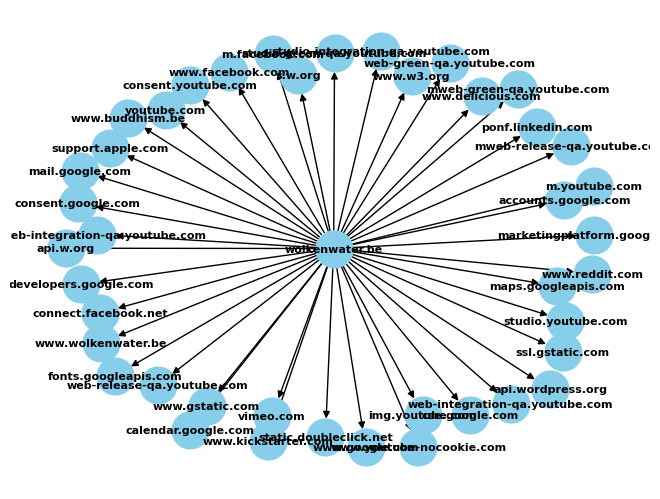

In [2]:
from warcio.archiveiterator import ArchiveIterator
import networkx as nx
import tldextract
import matplotlib.pyplot as plt

graph = nx.DiGraph()

first_website = None
website_groups = {}

def get_root_domain(url):
    ext = tldextract.extract(url)
    return ext.registered_domain


with open('path/to/BE-942855-2457-99_P.warc.gz.gz', 'rb') as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response':
            url = record.rec_headers.get_header('WARC-Target-URI')
            if url.startswith("dns:"):
                url = url.replace("dns:", "")
                
                if first_website is None:
                    first_website = get_root_domain(url)
                    graph.add_node(first_website)

                current_root_domain = get_root_domain(url)
                
                common_root_domain = current_root_domain.split(".")[-2]

                if common_root_domain not in website_groups:
                    website_groups[common_root_domain] = [url]
                else:
                    website_groups[common_root_domain].append(url)

for group_name, websites in website_groups.items():
    for website in websites[1:]:
        graph.add_edge(first_website, website)


pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_weight='bold', arrows=True)
plt.show()

This graph already gives us quite a bit of information of all the websites wolkenwater.be links to, such as YouTube for videos, Gmail for some kind of sign up, Google Calendar likely for events, or, interestingly, buddhism.be, perhaps for further information on Buddhism in Belgium. From this, we can already derive quite a bit of information, but due to overlap and to repeating websites, we don't get a clean enough image. Let's now integrate all the other WARCs and see what each links to before cleaning it up.

In [81]:
import os
import glob
import gzip

website_groups = {}

warc_folder = 'path/to/Websites'

def get_root_domain(url):
    ext = tldextract.extract(url)
    return ext.registered_domain

for warc_file in glob.glob(os.path.join(warc_folder, '*.warc*')):
    first_website = None
    if warc_file.endswith('.gz'):
        stream = gzip.open(warc_file, 'rb')
    else:
        stream = open(warc_file, 'rb')
        
    with stream as stream:
        for record in ArchiveIterator(stream):
            if record.rec_type == 'response':
                url = record.rec_headers.get_header('WARC-Target-URI')
                if url.startswith("dns:"): 
                    url = url.replace("dns:", "")
                    
                    if first_website is None:
                        first_website = get_root_domain(url)
                        website_groups[first_website] = {}  
                
                    current_root_domain = get_root_domain(url)
                    common_root_domain = current_root_domain.split(".")[-2]

                    if common_root_domain not in website_groups[first_website]:
                        website_groups[first_website][common_root_domain] = 1
                    else:
                        website_groups[first_website][common_root_domain] += 1
                        
for main_website, sub_dict in website_groups.items():
    print(f"Website: {main_website}")
    for sub_domain, count in sub_dict.items():
        print(f"Sub-domain: {sub_domain}, Count: {count}")

Website: buddhism.be
Sub-domain: buddhism, Count: 1
Sub-domain: googleapis, Count: 1
Sub-domain: youtube, Count: 1
Sub-domain: gstatic, Count: 2
Sub-domain: domain, Count: 4
Sub-domain: example, Count: 1
Sub-domain: mustermann, Count: 1
Sub-domain: dominio, Count: 1
Sub-domain: domaine, Count: 1
Sub-domain: domene, Count: 2
Sub-domain: domena, Count: 2
Sub-domain: domainecarneros, Count: 2
Sub-domain: wixstatic, Count: 1
Sub-domain: google, Count: 1
Website: sgi-bel.org
Sub-domain: sgi-bel, Count: 2
Sub-domain: jquery, Count: 1
Sub-domain: googleapis, Count: 2
Sub-domain: google-analytics, Count: 1
Sub-domain: gstatic, Count: 2
Sub-domain: w3, Count: 1
Sub-domain: power4, Count: 1
Sub-domain: circ, Count: 1
Sub-domain: elastic, Count: 1
Sub-domain: back, Count: 1
Sub-domain: vimeo, Count: 4
Sub-domain: youtube, Count: 1
Sub-domain: youtube-nocookie, Count: 1
Sub-domain: vimeocdn, Count: 8
Sub-domain: akamaized, Count: 2
Sub-domain: schema, Count: 1
Sub-domain: newrelic, Count: 1
Sub-do

Before graphing, it may make sense to simply look at the websites linked in each file and how many times they appear. This way we know where we need to do some clean up. Additionally, we can also make inferences from this dictionary of domains: for example, samye.be makes use of google-analytics, which paired with their use of paypal may indicate an interest in driving traffic towards their website to sell some product or ask for donations from users.

In [27]:
import os
import glob
import gzip

website_groups_cleaned = {}

warc_folder = 'path/to/Websites'

common_domains = ['google', 'youtube', 'paypal', 'vimeo', 'wp', 'amazon'] # These are some common roots I've identified in my
                                                                          # WARCs after the previous step. You may find others
                                                                          # in yours; edit as needed. This method won't get rid
                                                                          # of all duplicates, but it will still make our data
                                                                          # look much neater.

def get_root_domain(url):
    ext = tldextract.extract(url)
    return ext.registered_domain

for warc_file in glob.glob(os.path.join(warc_folder, '*.warc*')):
    first_website = None
    if warc_file.endswith('.gz'):
        stream = gzip.open(warc_file, 'rb')
    else:
        stream = open(warc_file, 'rb')
        
    with stream as stream:
        for record in ArchiveIterator(stream):
            if record.rec_type == 'response':
                url = record.rec_headers.get_header('WARC-Target-URI')
                if url.startswith("dns:"): 
                    url = url.replace("dns:", "")
                    
                    if first_website is None:
                        first_website = get_root_domain(url)
                        website_groups_cleaned[first_website] = {}  
                
                    current_root_domain = get_root_domain(url)
                    common_root_domain = current_root_domain.split(".")[-2]
                    
                    for domain in common_domains:
                        if domain in common_root_domain:
                            if 'wp' in common_root_domain:
                                common_root_domain = 'wordpress'
                            else:
                                common_root_domain = domain
                            break
                    
                    if len(common_root_domain) > 3: 
                        if common_root_domain not in website_groups_cleaned[first_website]:
                            website_groups_cleaned[first_website][common_root_domain] = 1
                        else:
                            website_groups_cleaned[first_website][common_root_domain] += 1
                        
for main_website, sub_dict in website_groups_cleaned.items():
    print(f"Website: {main_website}")
    for sub_domain, count in sub_dict.items():
        print(f"Sub-domain: {sub_domain}, Count: {count}")

Website: buddhism.be
Sub-domain: buddhism, Count: 1
Sub-domain: google, Count: 2
Sub-domain: youtube, Count: 1
Sub-domain: gstatic, Count: 2
Sub-domain: domain, Count: 4
Sub-domain: example, Count: 1
Sub-domain: mustermann, Count: 1
Sub-domain: dominio, Count: 1
Sub-domain: domaine, Count: 1
Sub-domain: domene, Count: 2
Sub-domain: domena, Count: 2
Sub-domain: domainecarneros, Count: 2
Sub-domain: wixstatic, Count: 1
Website: sgi-bel.org
Sub-domain: sgi-bel, Count: 2
Sub-domain: jquery, Count: 1
Sub-domain: google, Count: 4
Sub-domain: gstatic, Count: 2
Sub-domain: power4, Count: 1
Sub-domain: circ, Count: 1
Sub-domain: elastic, Count: 1
Sub-domain: back, Count: 1
Sub-domain: vimeo, Count: 12
Sub-domain: youtube, Count: 2
Sub-domain: akamaized, Count: 2
Sub-domain: schema, Count: 1
Sub-domain: newrelic, Count: 1
Sub-domain: nr-data, Count: 1
Website: samye.be
Sub-domain: samye, Count: 1
Sub-domain: google, Count: 10
Sub-domain: jquery, Count: 1
Sub-domain: dailymotion, Count: 6
Sub-dom

Much better! Now we're grouping together all the URLs that use the same root, such as that all Google services are together. With this cleaner version, we can create a much more visually appealing graph that shows multiple WARCs and their networks.

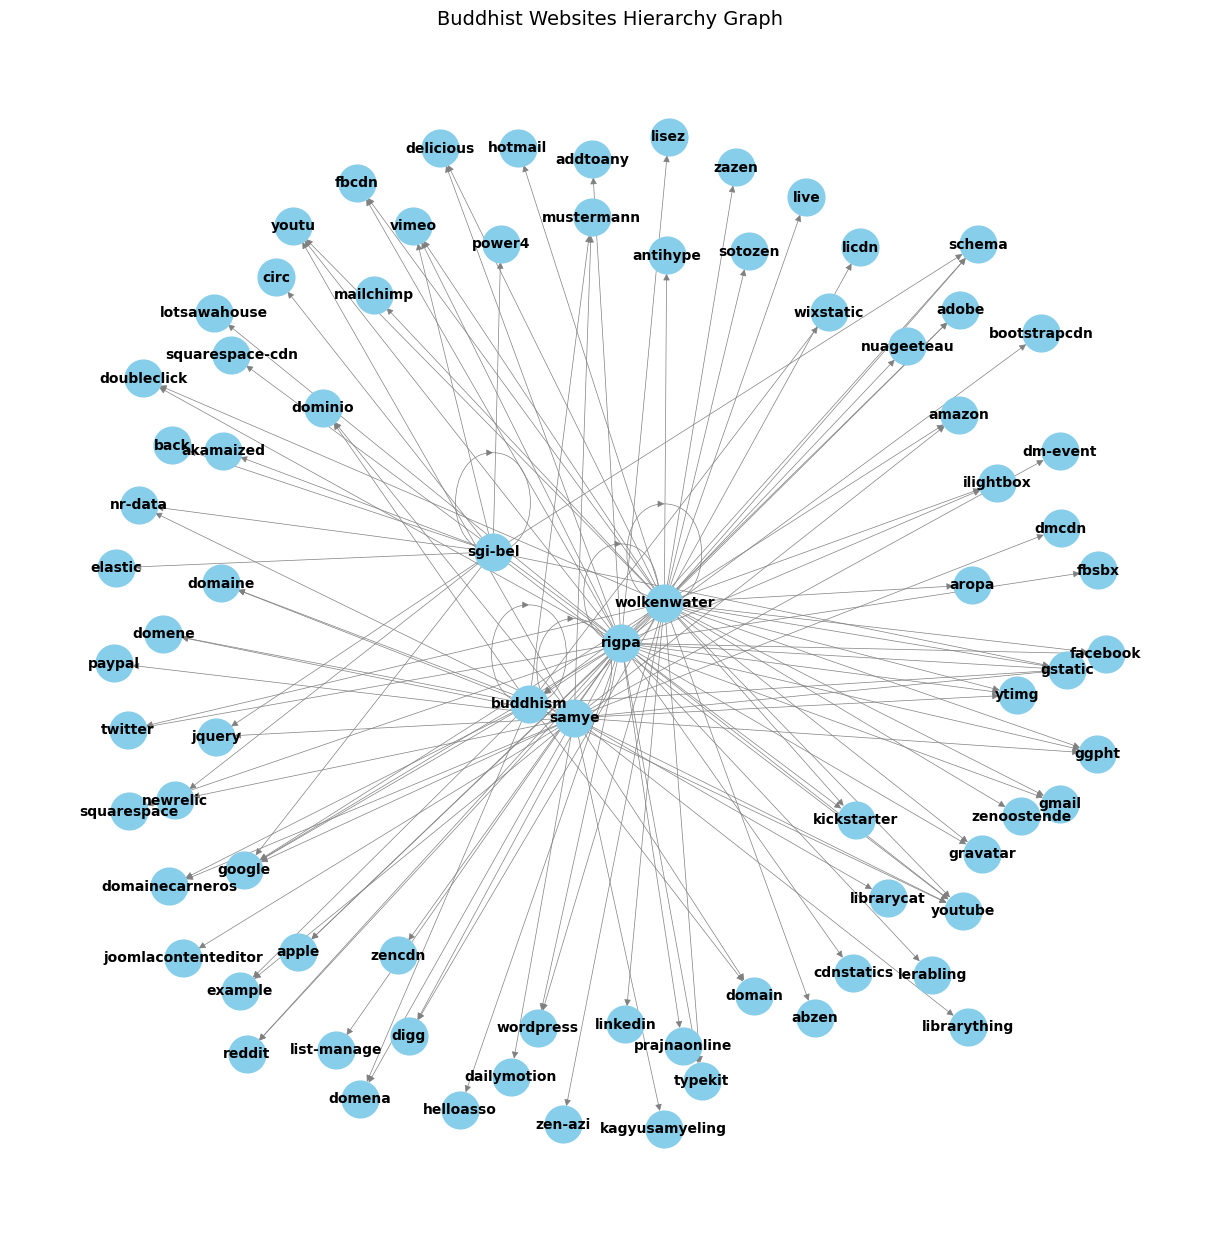

In [64]:
graph = nx.DiGraph()

for main_website, sub_dict in website_groups_cleaned.items():
    main_website_stripped = main_website.split('.')[0] 
    graph.add_node(main_website_stripped)
    
    for sub_domain, count in sub_dict.items():
        graph.add_edge(main_website_stripped, sub_domain)

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(graph, seed=48, k=0.3, iterations=20)

nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold', arrows=True, edge_color='gray', width=0.5)

plt.title('Buddhist Websites Hierarchy Graph', fontsize=14)
plt.axis('off')
plt.show()

This much cleaner graph helps in analyzing the network of websites linked in the Buddhist WARCs: we can see that many, if not all, link to Google, indicating that they may all use different Google services; similarly, all of them also point at YouTube, showcasing that instructional videos may be an indispensable feature in these websites.

We can, however, create much neater and interactive graphs using Gephi. In order to do so, we need to convert our cleaned dictionary into a couple of CSV files so that we may import them into the Gephi software.

In [79]:
import csv
with open("edges.csv", "w", newline="", encoding="utf-8") as csvfile:

    writer = csv.writer(csvfile)

    writer.writerow(["Source", "Target", "Type", "Weight"])

    for main_website, sub_domains in website_groups_cleaned.items():
        main_website_stripped = main_website.split('.')[0]
        for sub_domain, count in sub_domains.items():
            writer.writerow([main_website_stripped, sub_domain, 'Directed', count])

with open("nodes.csv", "w", newline="", encoding="utf-8") as csvfile2:
    writer = csv.writer(csvfile2)
    writer.writerow(['ID'])
    for main_website, sub_domains in website_groups_cleaned.items():
        main_website_stripped = main_website.split('.')[0]
        writer.writerow([main_website_stripped])

In order to create your own graph, import nodes.csv as Nodes Table, and edges.csv as Edges Table. From that point onwards, you can experiment with Gephi to obtain the results you wish. I also recommend following this guide: https://medium.com/data-analytics-at-nesta/how-to-create-network-visualisations-with-gephi-a-step-by-step-tutorial-e0743c49ec72
The data is already set up for you if you executed all the code above, so you can skip Stage 1 and go directly into Stage 2.

Here is the graph I created on Gephi. The main websites are italicized and boldened. The more each main website links to other links, the bigger their circle becomes. The more each domain is linked to, the darker their circle becomes. The more a particular main website links to another website, the darker the arrow connecting them becomes. As we can see, out of all our main websites, buddhism.be is the one that is linked to most often. Similarly, YouTube and Google are the most linked websites all accross the board, with rigpa and wolkenwater linking them most often.  Lastly, wolkenwater is the website that uses the most links, while buddhism uses the least. Other Buddhist websites, such as zen-azi or kagyusamyeling are linked, showing that some of the centers may be connected with each other. 

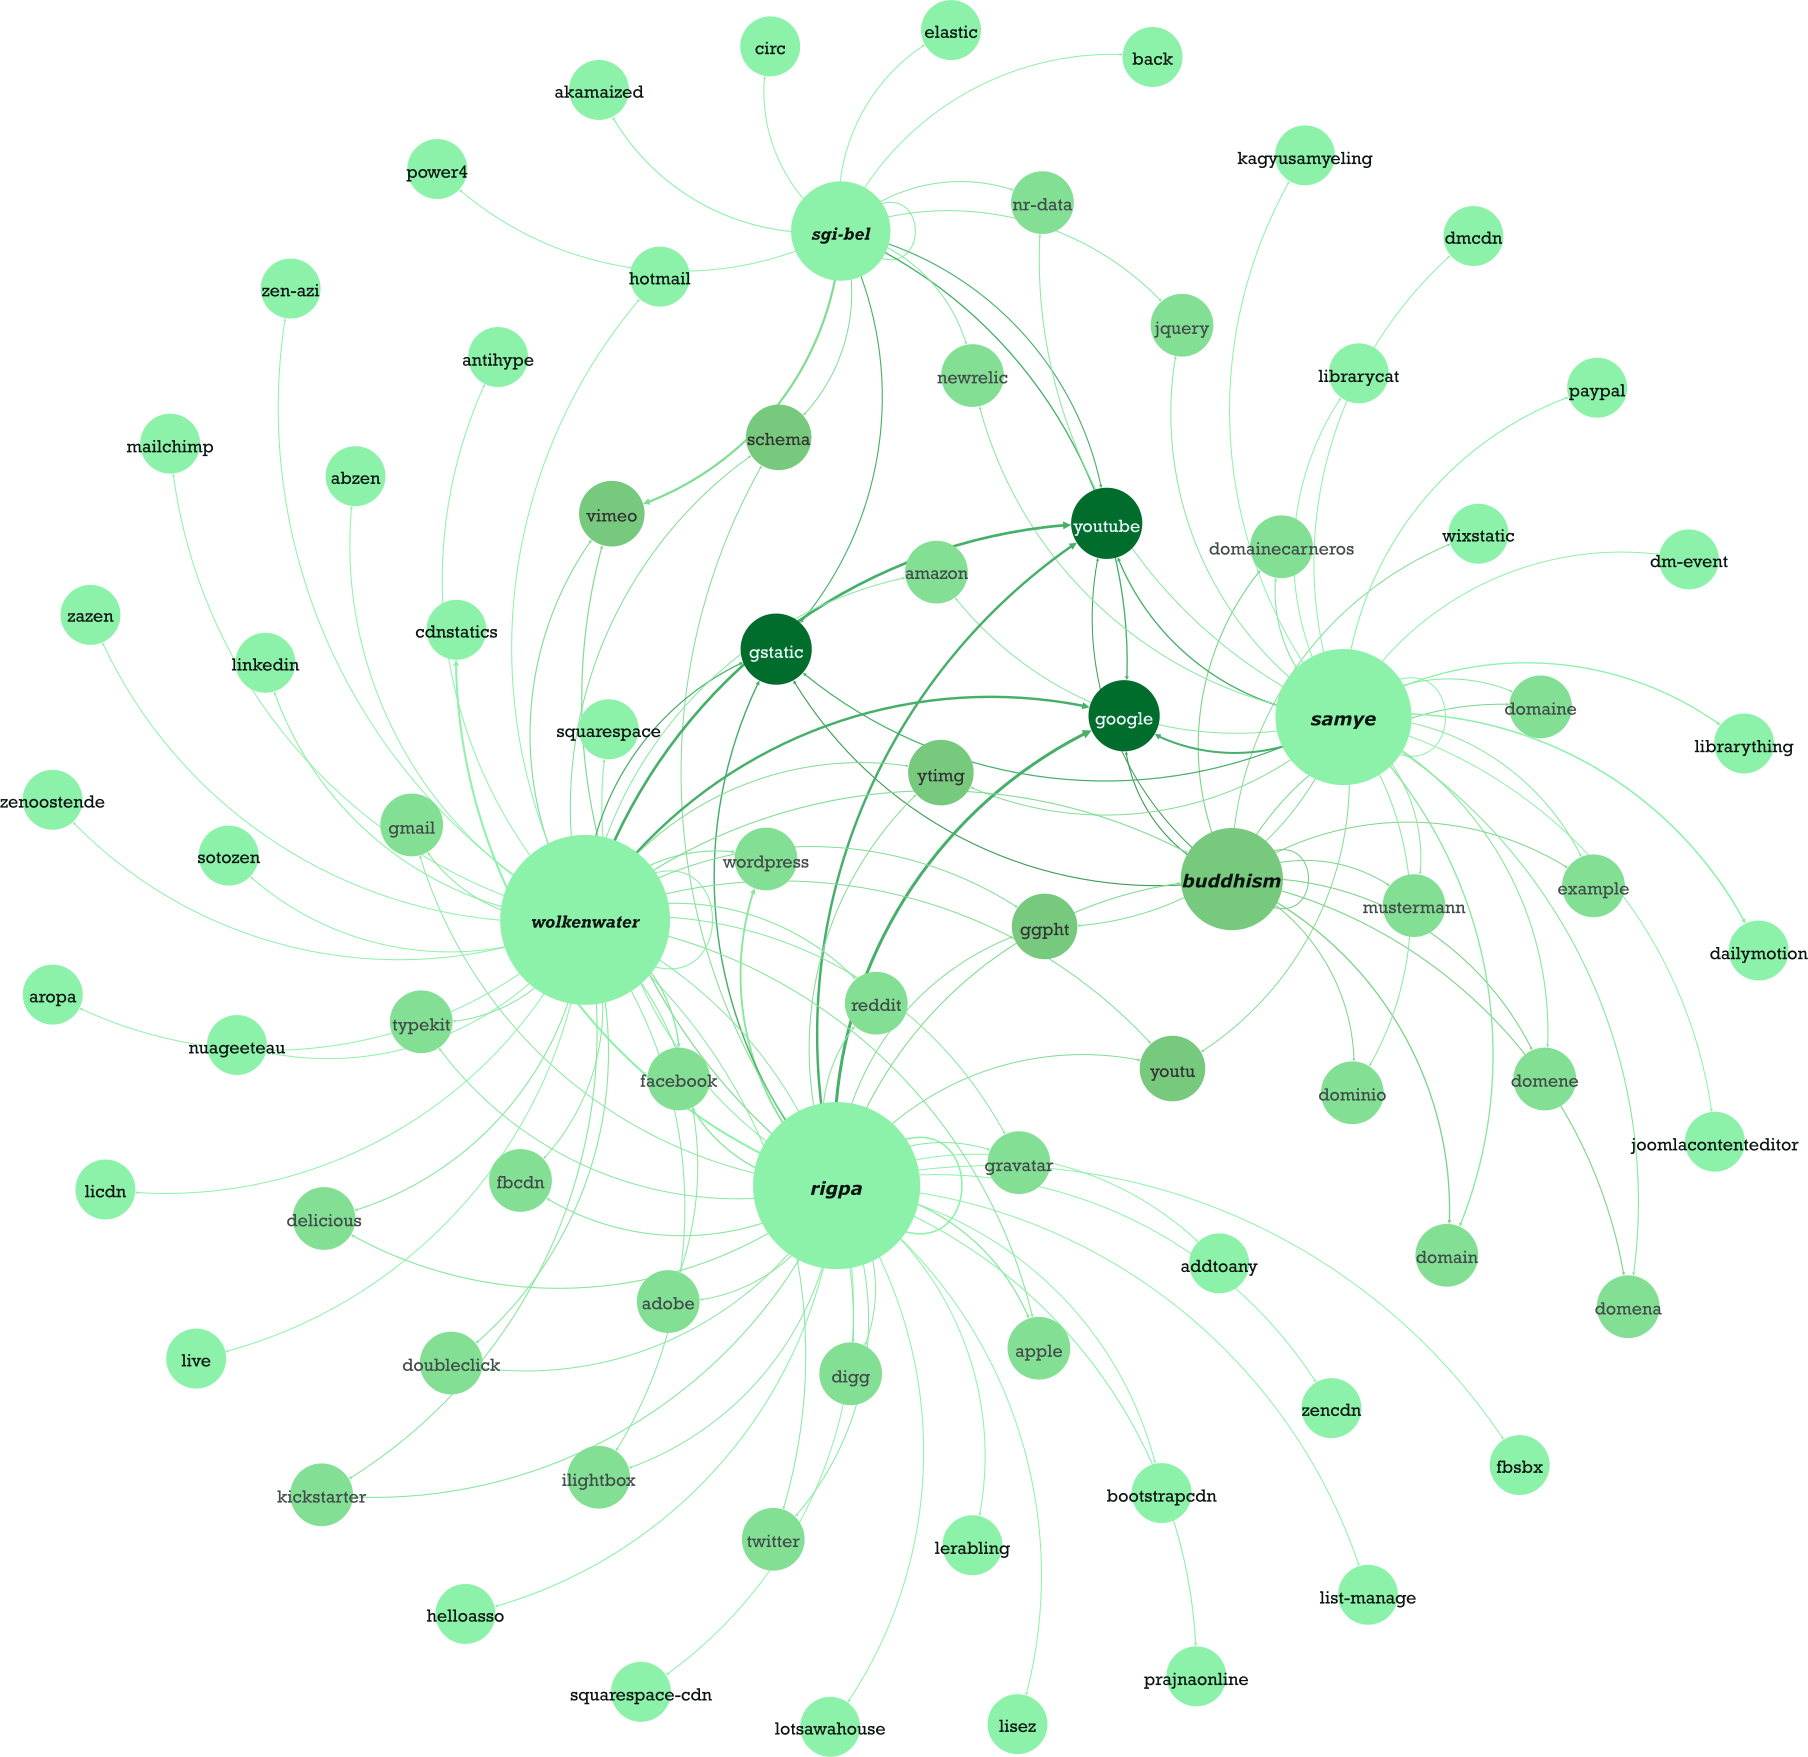

Within the Gephi interface, you can also interact with the graph in a much less stylized version of it. Here is the same graph in the Overview window:

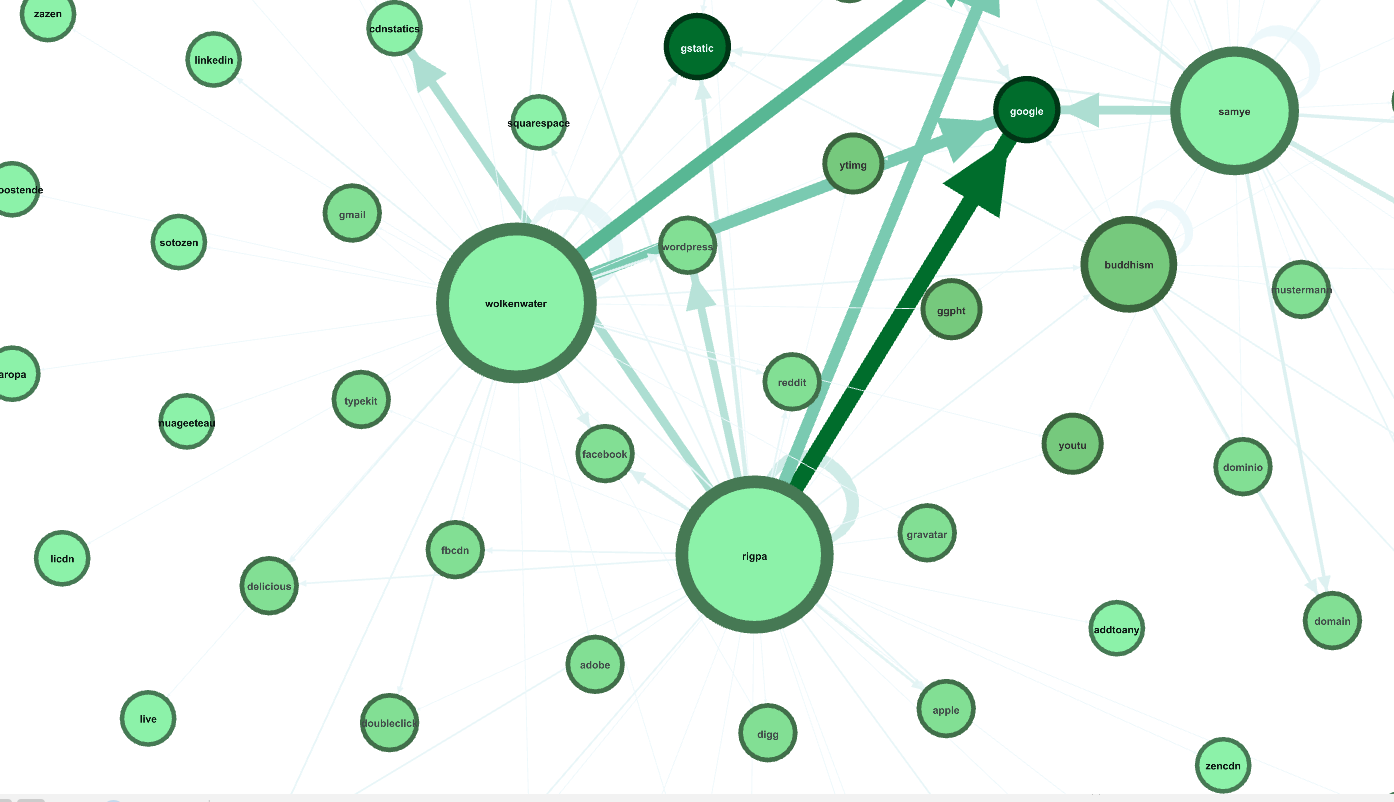

Here is the same graph in the Overview window when I hover over rigpa:

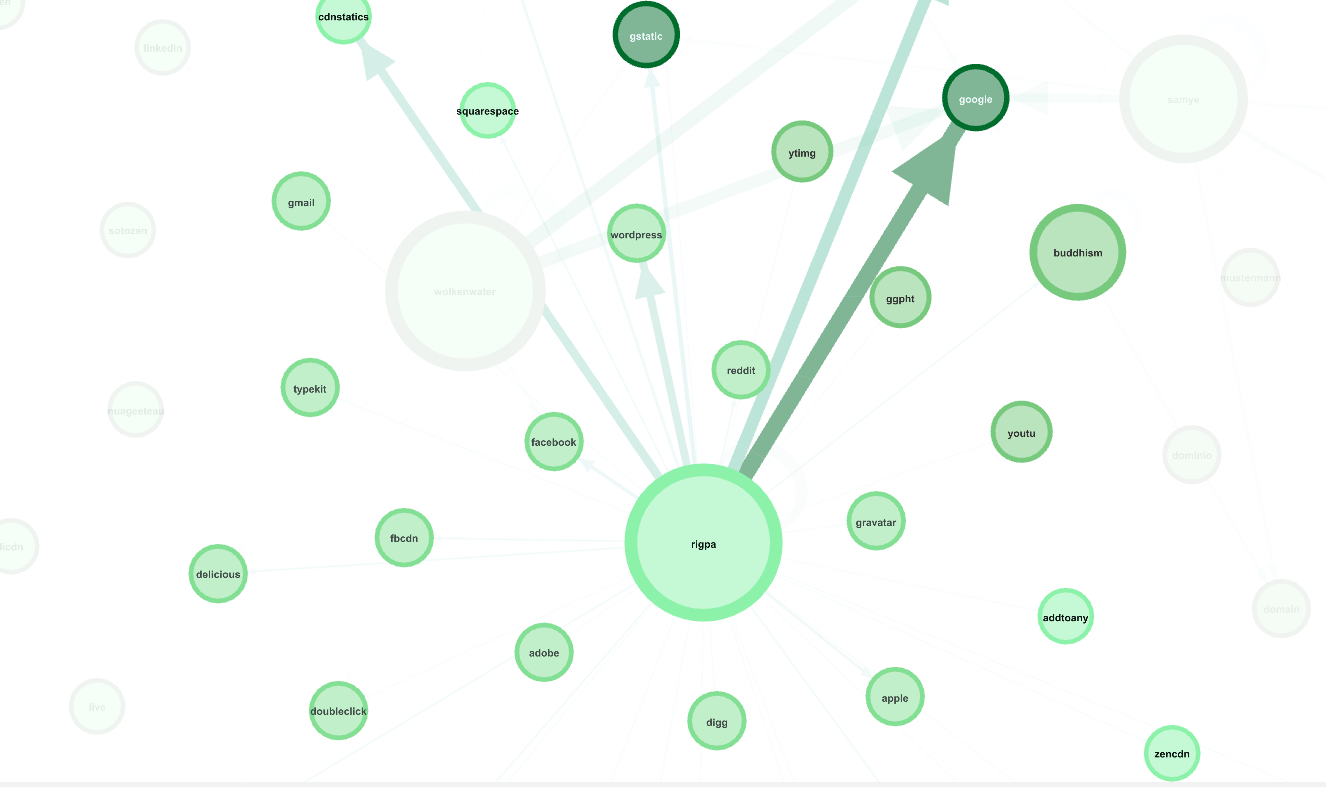

By using Gephi, you can easily create beautiful representations of the website network uniting your WARCs, while you can also use its interactivity to learn more about this network.

In the same folder where you found this notebook, you can also find my nodes.csv and edges.csv files if you wish to import them to Gephi. Additionally, you can also find my .gephi file if you want to play around with the graphs above.

Lastly, let's check the extensions of the websites linked in each WARC. In doing so, we can learn more about whether these websites have an international community that they link in their content.

In [85]:
extensions_websites = {}
for warc_file in glob.glob(os.path.join(warc_folder, '*.warc*')):
    first_website = None
    if warc_file.endswith('.gz'):
        stream = gzip.open(warc_file, 'rb')
    else:
        stream = open(warc_file, 'rb')
        
    with stream as stream:
        for record in ArchiveIterator(stream):
            if record.rec_type == 'response':
                url = record.rec_headers.get_header('WARC-Target-URI')
                if url.startswith("dns:"): 
                    url = url.replace("dns:", "")
                    
                    if first_website is None:
                        first_website = get_root_domain(url)
                        extensions_websites[first_website] = {}  
                
                    current_root_domain = get_root_domain(url)
                    domain_extension = current_root_domain.split(".")[-1]

                    if domain_extension not in extensions_websites[first_website]:
                        extensions_websites[first_website][domain_extension] = 1
                    else:
                        extensions_websites[first_website][domain_extension] += 1
                        
for main_website, ext_dict in extensions_websites.items():
    print(f"Website: {main_website}")
    for extension, count in ext_dict.items():
        print(f"Extension: {extension}, Count: {count}")

Website: buddhism.be
Extension: be, Count: 1
Extension: com, Count: 13
Extension: de, Count: 1
Extension: hu, Count: 2
Extension: no, Count: 2
Extension: pl, Count: 2
Website: sgi-bel.org
Extension: org, Count: 4
Extension: com, Count: 22
Extension: in, Count: 4
Extension: net, Count: 3
Website: samye.be
Extension: be, Count: 3
Extension: com, Count: 41
Extension: net, Count: 4
Extension: de, Count: 1
Extension: hu, Count: 2
Extension: pl, Count: 2
Extension: no, Count: 2
Extension: org, Count: 2
Website: rigpa.be
Extension: be, Count: 5
Extension: com, Count: 85
Extension: org, Count: 12
Extension: net, Count: 7
Extension: fr, Count: 1
Extension: nl, Count: 2
Extension: gl, Count: 1
Extension: info, Count: 2
Extension: uk, Count: 1
Website: wolkenwater.be
Extension: be, Count: 10
Extension: com, Count: 63
Extension: net, Count: 6
Extension: org, Count: 10
Extension: eu, Count: 1
Extension: fr, Count: 1
Extension: jp, Count: 1


As we can see, quite a few of these websites link to outside of Belgium. Although extensions such as fr or nl may simply indicate the existence of different versions of the websites in different languages, some of these extensions may indicate a larger international community. Samye links to .pl (Polish), .hu (Hungarian), and .de (German) websites, while wolkenwater goes as far as to Japan (.jp). In researching these extensions, we can see that some of these Buddhist websites are quite connected to international branches of Buddhism!

This concludes this guide for website networks exploration usign warcio and Gephi!